In [1]:
import datetime
import gspread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import openai
from oauth2client.service_account import ServiceAccountCredentials

### 設定並連接 Google Sheets API

In [2]:
# 設定 Google Sheets API 權限範圍
SCOPES = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]

# 你的服務帳戶金鑰檔案路徑
SERVICE_ACCOUNT_FILE = "C:\\Users\\vanes\\Downloads\\institutional-care-ab4817c0a31d.json" 

# 進行授權
creds = ServiceAccountCredentials.from_json_keyfile_name(SERVICE_ACCOUNT_FILE, SCOPES)
client = gspread.authorize(creds)

# 使用 Google Sheet ID 打開表單
# 可以在 Google Sheets URL 中找到它
sheet = client.open_by_key("1AC8gr5w1IYIH4wy37ANvs1U3Ux_8XVNOWgPY1R43Zw0") # 用你自己的 Sheet ID 替換
info =  sheet.worksheet('infomation')  
response=   sheet.worksheet('Form Responses 1')

# 讀取數據
info_data = info.get_all_records()
data= pd.DataFrame(response.get_all_records())
print(info_data)


[{'Email Address': '111702034@g.nccu.edu.tw', 'Name': 'Alice'}, {'Email Address': '111702033@g.nccu.edu.tw', 'Name': 'Lily'}]


### 發送郵件

In [97]:
# 📌 Google Form 連結（請填入你的表單網址）
GOOGLE_FORM_URL = "https://forms.gle/Jp4HShDxykiEAp4s9"

# 📧 Gmail 設定
SENDER_EMAIL = "christine921117@gmail.com"
SENDER_PASSWORD = "fxzmflqpblyiyeeg"


# 📅 取得當月份名稱（e.g., "March"）
month_name = datetime.datetime.now().strftime("%B")
from email.header import Header
# ✉️ 發送郵件
def send_email(to_email, name):
    msg = MIMEMultipart()
    msg["From"] = SENDER_EMAIL
    msg["To"] = to_email
    msg["Subject"] = Header(f"【{month_name}】心理健康調查表填寫通知", 'utf-8')

    # 📝 郵件內容
    body = f"""
親愛的 {name}，

這是本月的機構養育和心智發展關聯性的問卷，請點擊下方連結填寫：
🔗 {GOOGLE_FORM_URL}

請依照自己想法或感覺符合句子描述的程度來填答。
您的回饋對我們非常重要，謝謝您的參與！
    
祝好，
國立政治大學輔導與諮商碩士學位學程 
    """
    msg.attach(MIMEText(body, "plain", _charset="utf-8"))

    
    try:
        # 📨 連接 Gmail 並發送
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.ehlo('localhost')
            server.login(SENDER_EMAIL, SENDER_PASSWORD)
            server.sendmail(SENDER_EMAIL, to_email, msg.as_string())
        print(f"郵件已成功發送給 {name}")
    except Exception as e:
        print(f"發送郵件時出現錯誤: {e}")

# 🔄 發送給所有受試者
for person in info_data:
    email = person['Email Address'] 
    name = person['Name']
    send_email(email , name)

print("📧 本月心理健康表單已成功發送給所有受試者！")



郵件已成功發送給 Alice
郵件已成功發送給 Lily
📧 本月心理健康表單已成功發送給所有受試者！


### 計算心理健康指數 

In [3]:
def calculate_BSRS(row):
    health_index = sum(row[['1. 最近一週會不會「覺得緊張或不安」？', 
                            '2. 最近一週會不會「覺得容易苦惱或動怒」？', 
                            '3. 最近一週會不會「感覺憂鬱、心情低落」？', 
                            '4. 最近一週會不會「覺得比不上別人」？', 
                            '5. 最近一週會不會「覺得睡眠困難，譬如難以入睡、易醒或早醒」？']]) * 5
    
    
    
    if pd.to_numeric(row['6. 這一個月來，有自殺的想法？'], errors='coerce') >= 2:
        referral_advice = (
        "🚨 **重要提醒：你的回應顯示你最近有較強烈的自殺想法，這是一個需要特別關注的訊號。**\n\n"
        "💡 **請不要獨自承擔這些情緒，你並不孤單！** 找一位值得信任的親友談談，或考慮尋求心理專業人士的協助。\n\n"
        "🏥 **如果你的情緒非常低落，甚至有強烈的自我傷害或自殺衝動，請立即尋求幫助。**\n"
        "📞 **請撥打 1925（台灣安心專線），或尋找最近的心理健康資源，專業人士可以幫助你度過這段困難時期。**\n\n"
        "🌱 **這些情緒並不代表你的全部，請給自己一個機會，你值得被幫助，也值得擁有更好的生活！💛**"
    )
    else:
        referral_advice = ""
        
    if health_index >= 75:
        BSRS_feedback = "🌟 你的情緒狀態非常穩定，情緒適應良好，保持目前的生活步調！\n" \
                    "如果你感到稍微疲憊或低落，也不必過度擔心，偶爾的波動是正常的。保持積極的心態，繼續照顧自己！💖"
    elif 50 <= health_index < 75:
        BSRS_feedback = "⚠️ 情緒狀態有些波動，可能會開始影響到日常生活，建議你尋求心理諮詢或專業人士的幫助。\n" \
                    "一步一步來，你可以調整自己，讓專業人士協助你找到合適的調適方式💜"
    elif 25 <= health_index < 50:
        BSRS_feedback = "❗情緒狀況偏低，壓力可能已經對你的生活造成一定影響。這時候，你可能會感到焦慮、疲憊或低落，建議尋求心理諮詢來處理這些情緒。\n" \
                    "試著與信任的朋友或家人溝通，或進行運動來舒解壓力。別忘了，專業的幫助能讓你走出困境💛"
    else: 
        BSRS_feedback = "🚨 你的情緒狀況目前非常低落，可能對日常生活造成了嚴重的影響。這樣的情緒狀態不容忽視，建議立刻尋求心理治療或精神科專業協助。\n" \
                    "你值得被幫助，並且值得過更好的生活。別猶豫，採取行動來改善情況，讓自己重拾希望💔"
        
    return health_index, BSRS_feedback, referral_advice
    

data[['HealthIndex', 'BSRS_Feedback', 'ReferralAdvice']] = data.apply(calculate_BSRS, axis=1, result_type='expand')

### 計算 RFQ_U / RFQ_C

In [4]:
def calculate_rfq(row):
    rfq_c_weights = [3, 2, 1, 0, 0, 0, 0]  # 定義 RFQ-C 的評分標準
    rfq_u_weights = [0, 0, 0, 0, 1, 2, 3]  # 定義 RFQ-U 的評分標準

    rfq_c = sum(rfq_c_weights[v - 1] for v in row[['1. 我猜不出他人的想法。',
                                               '2. 對於我所做的事情，我並不總是知道為什麼要這樣做。',
                                               '3. 當我生氣時會說出一些氣話，而我卻不知道為什麼會這麼說。',
                                               '4. 當我生氣時，我會說一些事後會後悔的話。',
                                               '5. 如果我對自己沒有把握，我可能會做出冒犯他人的行為。',
                                               '6. 有時我會做一些不確切知道為什麼要去做的事。']]) / 6
    rfq_u = sum(rfq_u_weights[v - 1] for v in row[['2. 對於我所做的事情，我並不總是知道為什麼要這樣做。', 
                                                                 '4. 當我生氣時，我會說一些事後會後悔的話。', 
                                                                 '5. 如果我對自己沒有把握，我可能會做出冒犯他人的行為。', 
                                                                 '6. 有時我會做一些不確切知道為什麼要去做的事。',
                                                                 '7. 我總是知道我的感受。',
                                                                 '8. 強烈的感覺總能擾亂我的情緒。']]) / 6
    
    if rfq_c > 1 and rfq_u >= 2:
        rfq_feedback = "你可能同時容易過度解讀他人的行為，但又對自己的內在狀態不確定。這可能讓你在社交互動時感到焦慮或困惑，建議透過書寫、對話來整理思緒，幫助自己建立更穩定的內在覺察。"
    elif rfq_c > 1 and rfq_u < 2:
        rfq_feedback ="你能夠理解自己的情緒，但可能會過度解讀他人的行為，容易想太多。試著練習放慢思考，不要急著解釋或揣測對方的意圖，給自己一些喘息的空間。"
    elif rfq_c <= 1 and rfq_u >= 2:
        rfq_feedback = "你不會過度解讀他人，但可能較難理解自己的情緒和行為模式。這可能讓你在面對壓力時較難做出適當調適，建議透過日記或與信任的人討論來提升自我覺察能力。"
    else:  # rfq_c <= 1 and rfq_u < 2
        rfq_feedback = "你的心智化能力較為平衡，能夠適當理解自己的情緒，並不會過度解讀他人的行為。這是一個穩定的狀態，持續關注自己的心理健康，適時調整即可！"
    
    return rfq_c, rfq_u, rfq_feedback
    
data[['RFQ_C','RFQ_U', 'RFQ_Feedback']] = data.apply(calculate_rfq, axis=1, result_type='expand')

### 計算個人困擾

In [5]:
dimensions = {
    "生涯相關困擾": ["請依個人感受，點選符合您情形的數字。\n [生涯困擾]", "請依個人感受，點選符合您情形的數字。\n [學習困擾]"],
    "情緒與心理健康困擾": ["請依個人感受，點選符合您情形的數字。\n [情緒困擾]", "請依個人感受，點選符合您情形的數字。\n [精神困擾]"],
    "人際關係困擾": ["請依個人感受，點選符合您情形的數字。\n [人際困擾]", "請依個人感受，點選符合您情形的數字。\n [感情困擾]", "請依個人感受，點選符合您情形的數字。\n [家庭困擾]"],
    "生活與時間管理困擾": ["請依個人感受，點選符合您情形的數字。\n [時間管理]", "請依個人感受，點選符合您情形的數字。\n [生活困擾]"],
    "生理健康困擾": ["請依個人感受，點選符合您情形的數字。\n [生理困擾]"]
}
# 計算個人平均分數
def calculate_personal_scores(row):
    scores = {}
    for dimension, categories in dimensions.items():
        scores[dimension] = row[categories].mean()  # 計算該指標的平均值
    return pd.Series(scores)

personal_scores = data.apply(calculate_personal_scores, axis=1)
data = pd.concat([data, personal_scores], axis=1)

### 計算群體的平均值

In [126]:
def calculate_group_average_by_month(data):
    monthly_averages = {}

    # 取得所有月份的獨特值
    unique_months = data['這次填寫的是幾月份的記錄'].unique()

    for target_month in unique_months:
        # 篩選出當月的數據
        monthly_data = data[data['這次填寫的是幾月份的記錄'] == target_month]

        # 初始化該月份的結果
        monthly_averages[target_month] = {}

        for dimension, categories in dimensions.items():
            # 取出該分類的所有指標，轉為數值
            dimension_scores = monthly_data[categories].apply(pd.to_numeric, errors='coerce')

            # 計算該分類的平均值
            dimension_avg = dimension_scores.mean().mean()

            # 存入字典
            monthly_averages[target_month][dimension] = dimension_avg

    return monthly_averages

group_avg_scores = calculate_group_average_by_month(data)
group_avg_scores_df = pd.DataFrame(group_avg_scores).T 

In [ ]:
'''
import openai

def generate_personalized_advice(row):
    # 提取資料
    name = row["我是"]
    health_index = row["HealthIndex"]
    personal_scores = row[["生涯相關困擾", "情緒與心理健康困擾", "人際關係困擾", "生活與時間管理困擾", "生理健康困擾"]]
    
    # 從 row 提取其他反饋資料
    rfq_feedback = row["RFQ_Feedback"]
    bsrs_feedback = row["BSRS_Feedback"]
    referral_advice = row["ReferralAdvice"]
    
    # 建立 prompt
    prompt = f"""
    根據以下的心理測評數據，請提供個人化建議。
    
    用戶名稱: {name}
    健康指數: {health_index:.1f} (100 滿分)
    
    各項困擾指數:
    生涯相關困擾: {personal_scores['生涯相關困擾']}
    情緒與心理健康困擾: {personal_scores['情緒與心理健康困擾']}
    人際關係困擾: {personal_scores['人際關係困擾']}
    生活與時間管理困擾: {personal_scores['生活與時間管理困擾']}
    生理健康困擾: {personal_scores['生理健康困擾']}
    
    用戶的反饋:
    RFQ 反饋: {rfq_feedback}
    BSRS 反饋: {bsrs_feedback}
    轉介建議: {referral_advice}
    
    請根據這些資料提供個人化的建議，幫助用戶改善心理健康。
    """
    
    # 使用 OpenAI API 生成建議
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "你是一位心理諮詢師，請根據數據提供個人化建議。"},
            {"role": "user", "content": prompt}
        ]
    )
    
    # 返回生成的建議
    return response["choices"][0]["message"]["content"]

data['personalized_advice'] = data.apply(generate_personalized_advice, axis=1)

print(data[['我是', 'personalized_advice']])
'''

In [83]:
month_name = datetime.datetime.now().strftime("%b")

In [6]:
import os
import matplotlib.pyplot as plt

# 設定當前月份
current_month = "五月份"

# 定義月份順序，確保正確篩選
months = ['一月份', '二月份', '三月份', '四月份', '五月份', '六月份', 
          '七月份', '八月份', '九月份', '十月份', '十一月份', '十二月份']
current_month_index = months.index(current_month)  # 取得當前月份索引

# 產生資料夾來存圖片
output_folder = "健康趨勢圖"
os.makedirs(output_folder, exist_ok=True)

# **過濾只包含當前月份及之前的數據**
filtered_data = data[data["這次填寫的是幾月份的記錄"].apply(lambda x: months.index(x) <= current_month_index)]

# **計算每個月份的全體平均 HealthIndex**
average_trend = filtered_data.groupby("這次填寫的是幾月份的記錄")["HealthIndex"].mean().reset_index()
average_trend["month_index"] = average_trend["這次填寫的是幾月份的記錄"].apply(lambda x: months.index(x))  # 轉為數值索引
average_trend = average_trend.sort_values("month_index")  # 按月份排序

# **函數：繪製個人健康趨勢圖（包含全體平均趨勢）**
def plot_health_trend(person_data, name):
    selected_months = []
    selected_health_indexes = []

    # **過濾出當前月份及之前的數據**
    for index, entry in person_data.iterrows():
        if months.index(entry["這次填寫的是幾月份的記錄"]) <= current_month_index:
            selected_months.append(entry["這次填寫的是幾月份的記錄"])
            selected_health_indexes.append(entry["HealthIndex"])

    # **確保個人資料的 X 軸順序正確**
    month_indices = [months.index(m) for m in selected_months]  # 轉換為數值索引
    sorted_pairs = sorted(zip(month_indices, selected_health_indexes))  # 按月份排序
    sorted_month_indices, sorted_health_indexes = zip(*sorted_pairs) if sorted_pairs else ([], [])

    # **繪製個人趨勢**
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_month_indices, sorted_health_indexes, marker='o', linestyle='-', 
             color="dodgerblue", label='Personal Health Index')

    # **繪製全體平均趨勢**
    plt.plot(average_trend["month_index"], average_trend["HealthIndex"], marker='s', linestyle='--', 
             color="red", label='Average Health Index')

    # **圖表設定**
    plt.xticks(ticks=range(len(months)), labels=months, rotation=45)  # X 軸對應到月份
    plt.xlabel('Month')
    plt.ylabel('Health Index')
    plt.title(f'Health Trend for {name} Up To {current_month}')
    plt.grid(True)
    plt.legend()

    # **儲存圖表到檔案**
    filename = f"{output_folder}/{name}_health_trend.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✅ 圖表已儲存: {filename}")

# **計算每位用戶的健康趨勢圖**
for name in data['我是'].unique():
    person_data = data[data['我是'] == name]
    plot_health_trend(person_data, name)


C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(

✅ 圖表已儲存: 健康趨勢圖/Alice_health_trend.png
✅ 圖表已儲存: 健康趨勢圖/Max_health_trend.png


C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches="tight")
C:\Users\vanes\AppData\Local\Temp\ipykernel_31856\1181167115.py:59: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(

In [ ]:
'''
import openai

def generate_personalized_advice(row):
    # 提取資料
    name = row["我是"]
    health_index = row["HealthIndex"]
    personal_scores = row[["生涯相關困擾", "情緒與心理健康困擾", "人際關係困擾", "生活與時間管理困擾", "生理健康困擾"]]
    
    # 從 row 提取其他反饋資料
    rfq_feedback = row["RFQ_Feedback"]
    bsrs_feedback = row["BSRS_Feedback"]
    referral_advice = row["ReferralAdvice"]
    
    # 建立 prompt
    prompt = f"""
    根據以下的心理測評數據，請提供個人化建議。
    
    用戶名稱: {name}
    健康指數: {health_index:.1f} (100 滿分)
    
    各項困擾指數:
    生涯相關困擾: {personal_scores['生涯相關困擾']}
    情緒與心理健康困擾: {personal_scores['情緒與心理健康困擾']}
    人際關係困擾: {personal_scores['人際關係困擾']}
    生活與時間管理困擾: {personal_scores['生活與時間管理困擾']}
    生理健康困擾: {personal_scores['生理健康困擾']}
    
    用戶的反饋:
    RFQ 反饋: {rfq_feedback}
    BSRS 反饋: {bsrs_feedback}
    轉介建議: {referral_advice}
    
    請根據這些資料提供個人化的建議，幫助用戶改善心理健康。
    """
    
    # 使用 OpenAI API 生成建議
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "你是一位心理諮詢師，請根據數據提供個人化建議。"},
            {"role": "user", "content": prompt}
        ]
    )
    
    # 返回生成的建議
    return response["choices"][0]["message"]["content"]

data['personalized_advice'] = data.apply(generate_personalized_advice, axis=1)

print(data[['我是', 'personalized_advice']])
'''

In [7]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

#current_month = "三月份"  # 五月，請根據資料的格式調整

# 創建存圖的資料夾
output_folder = "困擾指數熱力圖"
os.makedirs(output_folder, exist_ok=True)

#filtered_data = data[data["這次填寫的是幾月份的記錄"] == current_month]

# 為每個人生成熱力圖
for person in data["我是"].unique():  # 取得所有人名
    # 過濾該人的所有紀錄，並以「這次填寫的是幾月份的記錄」作為橫軸
    person_data = data[data["我是"] == person].set_index("這次填寫的是幾月份的記錄")[
        ["生涯相關困擾", "情緒與心理健康困擾", "人際關係困擾", "生活與時間管理困擾", "生理健康困擾"]
    ]

    # 繪製熱力圖
    plt.figure(figsize=(8, 6))
    sns.heatmap(person_data.T, annot=True, cmap="Reds", center=5, linewidths=0.5, cbar=True)

    # 標題與格式調整
    plt.title(f"{person} 每月困擾指數", fontsize=14)
    plt.xlabel("月份", fontsize=12)
    plt.ylabel("困擾指標", fontsize=12)

    # 自動命名圖片檔案 (月份_名字_困擾指數.png)
    for month in person_data.index:
        file_name = f"{output_folder}/{month}_{person}_困擾指數.png"
        plt.savefig(file_name, dpi=300, bbox_inches="tight")

    plt.close()

print("✅ 所有熱力圖已存入資料夾！")


c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) Dej

✅ 所有熱力圖已存入資料夾！


c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\vanes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28079 (\N{CJK UNIFIED IDEOGRAPH-6DAF}) missing from font(s) Dej

<Figure size 800x500 with 0 Axes>

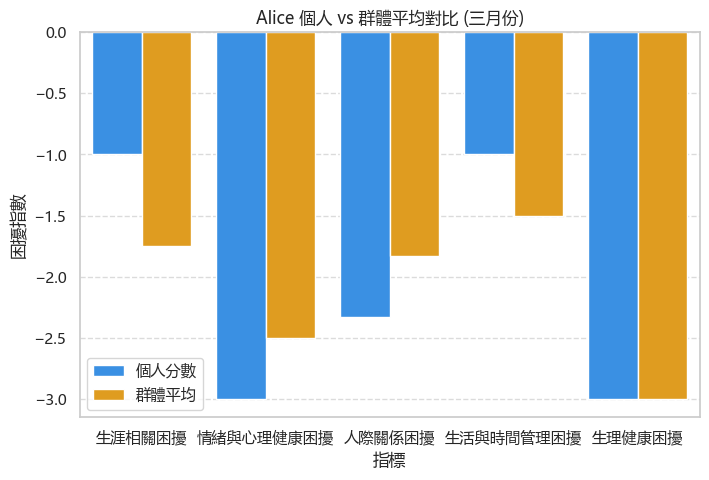

郵件已發送給 Alice (christine921117@gmail.com)


<Figure size 800x500 with 0 Axes>

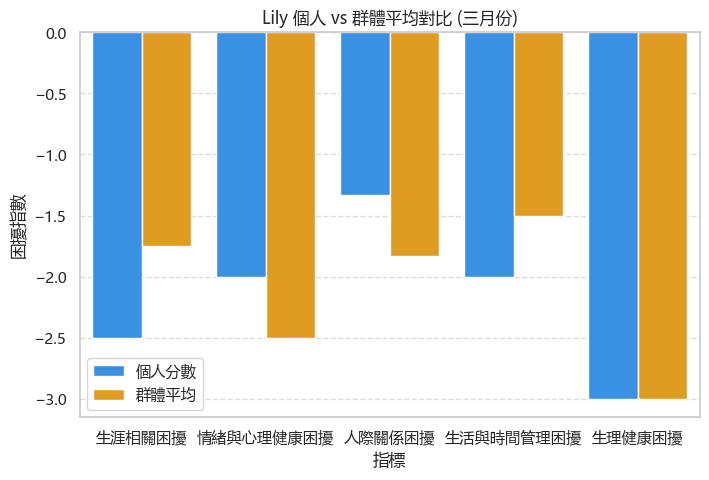

郵件已發送給 Lily (yucenliao0411@gmail.com)


In [ ]:
for index, entry in data.iterrows():
    current_month="五月份" #自己設
    if entry["這次填寫的是幾月份的記錄"] != current_month:
        continue
    name = entry["我是"]
    email = entry["Email Address"]
    personal_score = entry[["生涯相關困擾", "情緒與心理健康困擾", "人際關係困擾", "生活與時間管理困擾", "生理健康困擾"]]

    avg_scores = group_avg_scores_df.loc[current_month]

    labels = ["生涯相關困擾", "情緒與心理健康困擾", "人際關係困擾", "生活與時間管理困擾", "生理健康困擾"]
    avg_values = [avg_scores.get(label, 0) for label in labels]  # 用 `.get()` 避免 KeyError
    
      # 畫圖
    personal_values = personal_score.tolist()

    # 設定圖表大小
    plt.figure(figsize=(8, 5))

    df_plot = pd.DataFrame({
    "指標": labels * 2,   # 重複兩遍 labels
    "分數": personal_values + avg_values,  # 個人 & 群體數據合併
    "類別": ["個人分數"] * len(labels) + ["群體平均"] * len(labels)  # 類別標籤
})

    # 設定圖表大小
    plt.figure(figsize=(8, 5))

    # 繪製並排長條圖
    sns.barplot(data=df_plot, x="指標", y="分數", hue="類別", palette=["dodgerblue", "orange"])

    # 圖表標籤 & 標題
    plt.ylabel('困擾指數')
    plt.title(f'{name} 個人 vs 群體平均對比 ({current_month})')

    # 顯示圖例
    plt.legend()

    # 顯示網格線
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    filename = f"{name}_個人v.s群體平均對比.png"
    plt.savefig(filename)
    # 顯示圖表
    plt.show()

    # 儲存圖片
    
    plt.close()

    # 準備 email 內容
    health_index = data["HealthIndex"][index]
    health_feedback = data["BSRS_Feedback"][index]
    health_referral_advice = data["ReferralAdvice"][index]
    rfq_feedback = data["RFQ_Feedback"][index]

    email_body = f"""
Hi {name}，以下為你的本月心理測評結果！

📊 你的整體狀態
- 心理健康指數：{health_index:.1f} 分（100 滿分）
 {health_feedback} 

 {health_referral_advice}

- 自我覺察: 
{rfq_feedback}


"""

    # 發送郵件
    sender_email = "christine921117@gmail.com"
    sender_password = "fxzmflqpblyiyeeg"
    
    from email.mime.image import MIMEImage
    from pathlib import Path
    
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = email
    msg['Subject'] = f"{name} 的心理測評結果 ({current_month})"
    msg.attach(MIMEText(email_body, 'plain'))

    file_path = Path(filename)
    file_path1 = Path(f"{name}_health_trend.png")
    
    if file_path.exists() and file_path.is_file():
        with open(file_path, "rb") as attachment:
        # 使用 MIMEImage 附加圖片
            img_part = MIMEImage(file_path.read_bytes())
            img_part.add_header("Content-Disposition", "attachment", filename=filename)
            msg.attach(img_part)
            
        with open(file_path1, "rb") as attachment:
        # 使用 MIMEImage 附加圖片
            img_part1 = MIMEImage(file_path1.read_bytes())
            img_part1.add_header("Content-Disposition", "attachment", filename=f"{name}_health_trend.png")
            msg.attach(img_part1)
    else:
        print(f"檔案 {filename} 不存在或無法讀取")

  

    # 發送郵件
    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.ehlo('localhost')
        server.login(sender_email, sender_password)
        server.sendmail(sender_email, email, msg.as_string())

    print(f"郵件已發送給 {name} ({email})")
    

    

